In [1]:
'''
Analysis for "Technical considerations of MSK femoral cartilage segmentation using CNNs"

Compare distributions of testing probabilities among different 

@author: Arjun Desai, Stanford University
         (c) Stanford University, 2018
'''

import sys
sys.path.insert(0, '../')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as plttic

import os
import numpy as np
import scipy.io as sio
import scipy.stats as sis

import seaborn as sns
fsize = 12
params = {'legend.fontsize': fsize*0.925,          
          'axes.labelsize': fsize,
          'axes.titlesize':fsize*1.25,
          'xtick.labelsize':fsize*0.925,
          'ytick.labelsize':fsize*0.925}
sns.set(palette='pastel', rc=params)

import utils
from analysis import analysis_funcs as af
from analysis import stats
import h5py
import pandas as pd

import utils
from analysis import exp_filepaths as ef

def load_all_recon(dirpath):
    data = []
    for file in os.listdir(os.path.join(dirpath)):
        if file.endswith('.pred'):
            with h5py.File(os.path.join(dirpath, file)) as f:
                data.append(f['recon'][:])
    data = np.asarray(data)
    return data.flatten()

def load_recon_gt(dirpath):
    recon_data = []
    gt_data = []
    for file in os.listdir(os.path.join(dirpath)):
        if file.endswith('.pred'):
            with h5py.File(os.path.join(dirpath, file)) as f:
                recon_data.append(f['recon'][:])
                gt_data.append(f['gt'][:])
    recon_data = np.asarray(recon_data)
    gt_data = np.asarray(gt_data)
    return recon_data.flatten(), gt_data.flatten()


/home/arjundd/anaconda3/envs/tf_36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
num_bins = 101

bce_path = ef.LOSS_BCE
dice_path = ef.LOSS_DSC
wce_path = ef.LOSS_WCE
focal_path = ef.LOSS_FOCAL

cpal = sns.color_palette("pastel", 4)

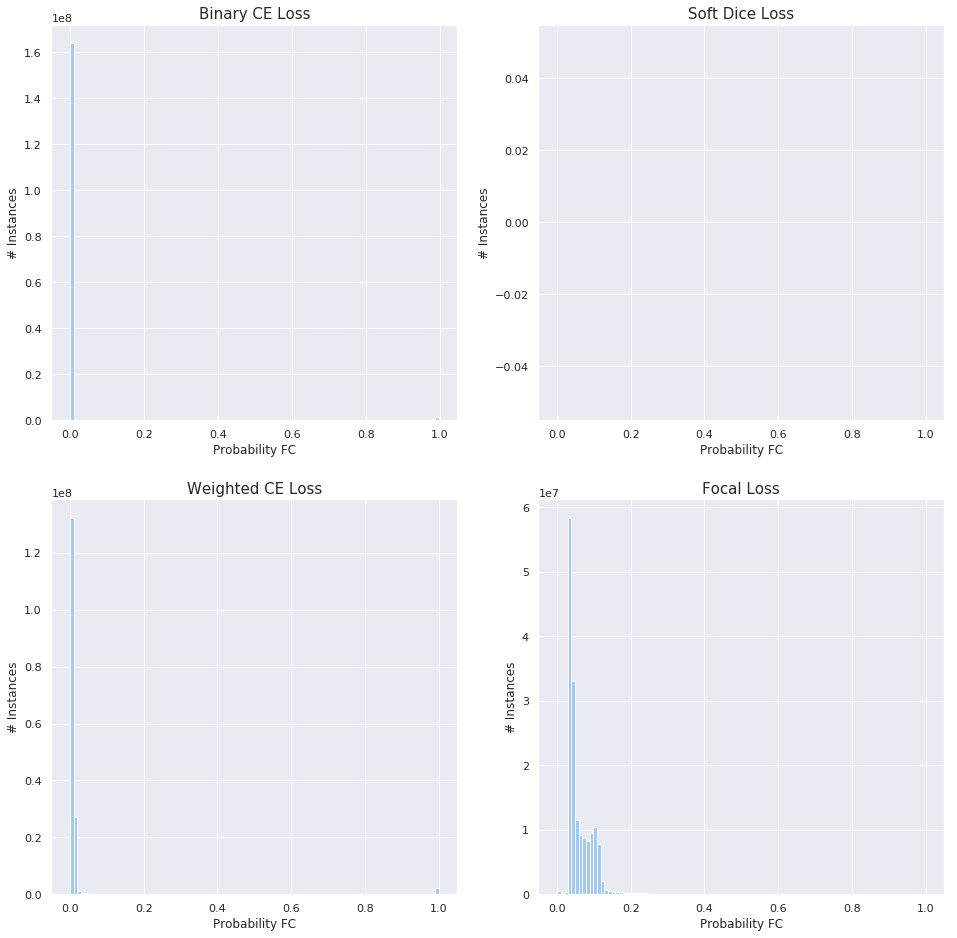

In [3]:
# Draw numbers with log
FL_recon, FL_gt = load_recon_gt(focal_path)
Dice_recon, Dice_gt = load_recon_gt(dice_path)
WCE_recon, WCE_gt = load_recon_gt(wce_path)
BCE_recon, BCE_gt = load_recon_gt(bce_path)

def draw_count(data, ax, title):
    ax.hist(data.flatten(), bins=num_bins, stacked=True)
    ax.set_xlabel('Probability FC')
    ax.set_ylabel('# Instances')
    ax.set_title(title)

# Initialize figure
fig, axs = plt.subplots(2, 2, figsize=(16,16))

# Focal Loss
draw_count(FL_recon, axs[1][1], 'Focal Loss')

# Dice
draw_count(Dice_recon, axs[0][1], 'Soft Dice Loss')

# WCE
draw_count(WCE_recon, axs[1][0], 'Weighted CE Loss')

# BCE
draw_count(BCE_recon, axs[0][0], 'Binary CE Loss')

plt.show()

In [4]:
def draw_incorrect(recon, gt, ax=None, title=None, normalize=False):
    false_positive_logits = np.asarray(recon <= 0.5, np.float64) * gt
    false_negative_logits = np.asarray(recon > 0.5, np.float64) * np.asarray(~np.asarray(gt, np.bool), np.float64)
    total = false_positive_logits + false_negative_logits
    
    assert (np.unique(total) == np.asarray([0,1])).all(), "All values must either be 0 or 1"
    
    total[total == 0] = np.nan
    data = recon * total
    data = data[~np.isnan(data)]
    
    if ax is None:
        return data.flatten()
    
    data = data.flatten()
    
    ax.hist(data, bins=num_bins, density=normalize)
    ax.set_xlabel('Probability FC')
    ax.set_title(title)
    
    counts, bin_edges = np.histogram(data, bins=10000)
    ax2 = ax.twinx()
    ax2.grid(None)
    cdf = np.cumsum(counts)
    
    normalization_factor = 100 if normalize else 1
    ax2.plot(bin_edges, np.insert(cdf/cdf[-1] * normalization_factor, 0, 0), linestyle='dashed', color='k')
    ax2.set_yticks(np.asarray([0, 0.2, 0.4, 0.6, 0.8, 1]) * normalization_factor)
    
    normalized_cdf = cdf/cdf[-1]
    d_center = np.abs(normalized_cdf - 0.5);
    print('Center density - %s: %0.3f' % (title, bin_edges[np.argmin(d_center)]))
    
    ax2.scatter(bin_edges[np.argmin(d_center)], normalized_cdf[np.argmin(d_center)] * normalization_factor, s=200, color='r', marker='*')
    
    return data.flatten()

Center density - (A) Binary CE Loss: 0.481


/home/arjundd/anaconda3/envs/tf_36/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


AttributeError: 'bool' object has no attribute 'all'

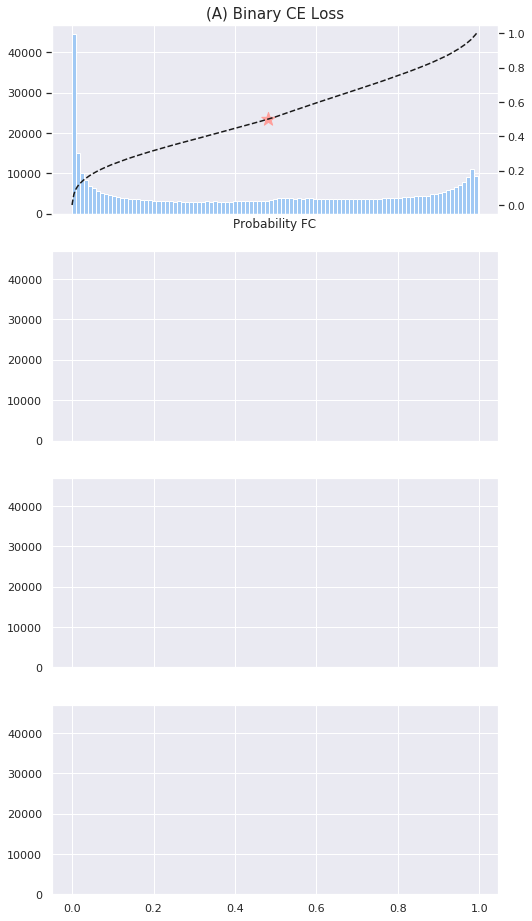

In [5]:
    
# Initialize figure
fig, axs = plt.subplots(4, 1, figsize=(8,16), sharey=True, sharex=True)

# BCE
BCE = draw_incorrect(BCE_recon, BCE_gt, axs[0], '(A) Binary CE Loss')

# Dice
Dice = draw_incorrect(Dice_recon, Dice_gt, axs[1], '(B) Soft Dice Loss')

# WCE
WCE = draw_incorrect(WCE_recon, WCE_gt, axs[2], '(C) Weighted CE Loss')

# Focal Loss
Focal = draw_incorrect(FL_recon, FL_gt, axs[3], '(D) Focal Loss')

fig.text(-0.02, 0.5, '# incorrect pixels', va='center', rotation='vertical', fontsize=fsize)
fig.text(1.02, 0.5, 'Cumulative Error Density', va='center', rotation=270, fontsize=fsize)

for ax in axs:
     ax.label_outer()

In [ ]:
# pdf
fig, axs = plt.subplots(4, 1, figsize=(8,16), sharex=True)

# BCE
BCE = draw_incorrect(BCE_recon, BCE_gt, axs[0], '(A) Binary CE Loss', normalize=True)

# Dice
Dice = draw_incorrect(Dice_recon, Dice_gt, axs[1], '(B) Soft Dice Loss', normalize=True)

# WCE
WCE = draw_incorrect(WCE_recon, WCE_gt, axs[2], '(C) Weighted CE Loss', normalize=True)

# Focal Loss
Focal = draw_incorrect(FL_recon, FL_gt, axs[3], '(D) Focal Loss', normalize=True)

fig.text(0, 0.5, 'Error Density (%)', va='center', rotation='vertical', fontsize=fsize*1.25)
fig.text(1, 0.5, 'Cumulative Error Density (%)', va='center', rotation=270, fontsize=fsize*1.25)
for ax in axs:
    ax.label_outer()
    
plt.savefig(os.path.join('/bmrNAS/people/arjun/msk_seg_networks/analysis/', '%s.png' % 'loss_dist'), format='png', dpi=1000, bbox_inches='tight')

In [ ]:
# Print Wasserstein distances between error distributions and 0.5-centered distribution
# Want all errors to be at 0.5
def print_wasserstein(data, name):
    densitys, bin_edges = np.histogram(data, bins=10000, density=True)
    xs = 0.5*(bin_edges[1:] + bin_edges[:-1])
    wd = sis.wasserstein_distance(xs, [0.5], u_weights=densitys)
    print('PDF Wasserstein Dist - %s: %0.5f' % (name, wd))

print_wasserstein(BCE, 'BCE')
print_wasserstein(Dice, 'Dice')
print_wasserstein(WCE, 'WCE')
print_wasserstein(Focal, 'Focal')

In [ ]:
# New figure
# fig, ax = plt.subplots(figsize=(16, 12))
# bins = np.linspace(0., 1., num=num_bins)
# FL = draw_incorrect(FL_recon, FL_gt)
# Dice = draw_incorrect(Dice_recon, Dice_gt)
# WCE = draw_incorrect(WCE_recon, WCE_gt)
# BCE = draw_incorrect(BCE_recon, BCE_gt)

# c = 0
# for loss, label in [(BCE, 'BCE', ), (Dice, 'Dice'), (WCE, 'WCE'), (FL, 'Focal')]:
#     sns.distplot(a=loss, bins=bins, hist=True, norm_hist=True, kde=False, label=label, ax=ax, color=cpal[c])
#     c += 1
    
# ax.set_xlabel('Probability FC')
# ax.set_ylabel('Error Density')
# ax.set_title('Pixelwise Error Distribution')
# ax.legend()

In [ ]:
#Get fits for FL (laplacian) and WCE (exponential/power-law)
bins = np.linspace(0., 1., num=num_bins)
x = np.array(0.5*(bins[1:] + bins[:-1]))

# Focal loss - laplacian
def laplacian_func(t, a, b):
    return 1/(2*b)*np.exp(-np.abs(t-a)/b)


FL_vals, _ = np.histogram(Focal, bins=bins)
popt, r2 = stats.fit(x, FL_vals, laplacian_func, [0.5, 1])
print(popt)
print(r2)

In [ ]:
# Get Error density for WCE > 0.5
counts, bin_edges = np.histogram(WCE, bins=100)
print('WCE - Percent error (p>0.5): %0.4f' % (np.sum(counts[50:]) / np.sum(counts)))

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import misc

sub1 = '9968800_V00/023.png'
sub2 = '9912946_V00/040.png'
sub3 = '9993650_V01/059.png'

subs = [sub1, sub2, sub3]

def show_sub_ims(base_path, show_title=False):
    fig = plt.figure(1, (13., 4.))

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 3),  # creates 1 x 3 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for i in range(len(subs)):
        sub = subs[i]
        im = misc.imread(os.path.join(base_path, 'im_ovlp', sub))
        grid[i].imshow(im)
        grid[i].grid(False)
        grid[i].set_xticks([])
        grid[i].set_yticks([])
        
        if show_title:
            sub_id = i + 1
            grid[i].set_title('Subject %d' % sub_id)
    plt.show()

def show_error_ims(base_path):
    fig = plt.figure(1, (13., 4.))

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 2),  # creates 1 x 3 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    sub = '9965231_V01'
    sub_slice = '%03d.png' % 23
    im_correct = misc.imread(os.path.join(base_path, 'im_ovlp_sep', sub, 'true_pos', sub_slice))
    im_err = misc.imread(os.path.join(base_path, 'im_ovlp_sep', sub, 'error', sub_slice))
    
    d = 180
    sy = 40
    sx = 90
    im_correct = im_correct[sy:sy+d, sx:sx+d, ...]
    im_err = im_err[sy:sy+d, sx:sx+d, ...]
    ims = [im_correct, im_err]
    
    for i in range(len(ims)):
        im=ims[i]
        grid[i].imshow(im)
        grid[i].grid(False)
        grid[i].set_xticks([])
        grid[i].set_yticks([])
        
    plt.show()

In [ ]:
# Image montage for BCE loss
show_sub_ims(bce_path, True)
show_error_ims(bce_path)

In [ ]:
# Image montage for Dice loss
show_sub_ims(dice_path)
show_error_ims(dice_path)

In [ ]:
# Image montage for WCE loss
show_sub_ims(wce_path)
show_error_ims(wce_path)

In [ ]:
# Image montage for Focal loss
show_sub_ims(focal_path)
show_error_ims(focal_path)

In [ ]:
# do false positive to false negative analysis
def fp_fn_stats(base_path, title):
    metrics = utils.load_pik(os.path.join(base_path, 'metrics.dat'))

    FPs = metrics['false_positive']
    FNs = metrics['false_negative']
    
    print('')
    results = stats.kruskal_dunn([FPs, FNs], ['FP', 'FN'])
    stats.print_results(results, 'FP vs FN - %s' % title)
    print('')
    print('FP/FN: %0.3f +/- %0.3f' % (np.mean(FPs / FNs), np.std(FPs/ FNs)))
    
fp_fn_stats(bce_path, 'BCE')
fp_fn_stats(dice_path, 'Dice')
fp_fn_stats(wce_path, 'WCE')
fp_fn_stats(focal_path, 'Focal')
